MIT License

Copyright (c) 2021 Jack Wolf, Nowak Research Group

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# generate training and testing data accoring to z=sign(y - (0.5*sin(pi*x)))
#
# parameters:
#  D: int: dimensions of data
#    1d data is a spline  
#    2d data is surface with sin decision boundary
#  N: int: total num. points
#  n: int: num. points to train on
# return (X_train, y_train), (X_test, y_test)
def Data(D, N, n):
  def fx(x):
    if D == 1:
      return (np.abs(x) >= 0.5).astype(int)*2 - 1
    elif D == 2:
      return np.sign(x[:,1] - (0.5*np.sin(np.pi*x[:,0])))
  X = np.random.uniform(low=-1, high=1, size=(N,D))
  y = fx(X)
  mask = np.array([False] * N)
  mask[:n] = True
  np.random.shuffle(mask)
  return (X[mask,:], y[mask]), (X[~mask,:], y[~mask])

In [11]:
# ReLU network with skip connections and regularization
class Model(torch.nn.Module):
  
  def __init__(self, input_nodes, relu_nodes, hidden_nodes, epochs, lr, reg_scale, reg_method):
    '''
    input nodes:  int, input dimensions of data
    relu_nodes:   int, width of relu layers
    hidden_nodeS: int, width of hidden linear layer
    epochs:       int, # of epochs to train for (regularization turned "on" 1/2 way through)
    lr:           float, learning rate value for optimizer (Adam)
    reg_scale:    float, scalar for regularization
    reg_method:   [0, 1, 2], indicating method of regularization
      0: no regularization
      1: sum of squares
      2: sum of squares of linear weights, sum of absolute value squared for ReLU weights
    '''
    super().__init__()
    self.epochs = int(epochs)
    self.lr = float(lr)
    self.reg_scale = float(reg_scale)
    if reg_method == 0:
      self.reg_method = lambda: 0
    elif reg_method == 1:
      self.reg_method = self.regularize_1
    elif reg_method == 2:
      self.reg_method = self.regularize_2
    self.input_nodes = int(input_nodes)
    self.relu_nodes = int(relu_nodes)
    self.hidden_nodes = int(hidden_nodes)
    self.l1 = torch.nn.Linear(self.input_nodes, self.relu_nodes)
    self.l2 = torch.nn.Linear(self.relu_nodes, self.hidden_nodes)
    self.l3 = torch.nn.Linear(self.hidden_nodes+self.input_nodes, self.relu_nodes)
    self.l4 = torch.nn.Linear(self.relu_nodes+self.hidden_nodes+self.input_nodes, 1)
    self.criterion = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-10)
  
  def sparsity(self):
    '''
    sparsity is the % of non-active nodes in the network by layer
    a non-active node is a node whose weight has magnitude smaller than a threshold value
    returns list of floats representing sparsity of each layer
    '''
    weights = [
      self.l1.weight,
      self.l2.weight, 
      self.l3.weight[:,:self.hidden_nodes],
      self.l4.weight[:,:self.relu_nodes]
    ]
    sparsities = []
    for w in weights:
      w = w.abs()
      threshold = 1e-3 * w.max()
      perc = (w < threshold).sum() / w.numel()
      sparsities.append(perc.detach().numpy().item())
    return np.array(sparsities)
    
  def forward(self, x):
    ''' forward pass input tensor x through network '''
    out1 = self.l1(x).clamp(min=0)
    out2 = self.l2(out1)
    out3 = self.l3(torch.cat([out2, x], 1)).clamp(min=0)  # concat for skips
    out4 = self.l4(torch.cat([out3, out2, x], 1))
    return out4
    
  def learn(self, x, y):
    '''
    train the model on input tensor x and target tensor y
    x: tensor of size [n, self.input_nodes]
    y: tensor of size [n,1] 
    returns float representing final value of loss fn + regularization
    '''
    x, y = torch.FloatTensor(x), torch.FloatTensor(y)
    regularization_on = self.epochs//2
    for e in range(self.epochs):
      if e == regularization_on:  # activate regularization halfway through
        print("turning on regularization")
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
      pred = self.forward(x)
      loss = self.criterion(pred, y)
      if e >= regularization_on:
        loss += self.reg_scale * self.reg_method()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      if e % 10000 == 0:
        print(f"{e}: {loss}")
    return loss.detach().numpy().item()

  def regularize_1(self):
    ''' 
    calculate sum of squares of weights in network 
    (excluding skip connection weights)
    '''
    r = 0
    sum_square = lambda l: l.detach().pow(2).sum().numpy().item()
    r += sum_square(self.l1.weight)
    r += sum_square(self.l2.weight)
    r += sum_square(self.l3.weight)
    r += sum_square(self.l4.weight)
    return r
  
  def regularize_2(self):
    ''' 
    calculate 
      sum of squares of linear-->ReLU weights +
      sum of absolute values squared of ReLU-->linear weights
    in network 
    (excluding skip connection weights)
    '''
    r = 0
    sum_square = lambda l: l.detach().pow(2).sum().numpy().item()
    square_sum_abs = lambda l: l.detach().abs().sum().pow(2).numpy().item()
    r += sum_square(self.l1.weight)
    r += square_sum_abs(self.l2.weight)
    r += sum_square(self.l3.weight)
    r += square_sum_abs(self.l4.weight)
    return r
  
  def predict(self, x):
    '''
    perform forward pass of model on input tensor x without computing gradients
    x: tensor of size [n, self.input_nodes]
    return array of size [n,1]
    '''
    x = torch.FloatTensor(x)
    pred = None
    with torch.no_grad():
      pred = self.forward(x)
    return pred.detach().numpy()

In [21]:
# run an experiment with the given parameters.
# train model on training set and evaluate on testing set
# record metrics and model sparsity
# graph results
#
# D: int, dimenions of data (1 or 2)
# n: int, number of training samples
# relu_width: int, width of relu layers in net
# linear_width: int, width of linear layer in net
# epochs: int, number of training epochs
# lr: float, learning rate
# reg_scale: float, scalar for regularization
# reg_method: int, which method of regularization (0, 1, or 2)
#
# return dict of parameters, dict of results, and (figure, axis) tuple
def experiment(D, n, relu_width, linear_width, epochs, lr, reg_scale, reg_method):
  params = {
    "Training samples": n,
    "ReLU dim": relu_width,
    "Linear dim": linear_width,
    "Training epochs": epochs,
    "Optimizer": "Adam",
    "LR": lr,
    "WD": "1e-10 --> 1e-3",
    "Regularization scalar": reg_scale,
    "Regularization method": reg_method
  }
  (X_train, y_train), (X_test, y_test) = Data(D, 1000, n)
  model = Model(D, relu_width, linear_width, epochs, lr, reg_scale, reg_method)
  train_loss = model.learn(X_train, y_train)
  pred = model.predict(X_test).flatten()
  y_test = y_test.flatten()
  acc = (np.sign(pred) == y_test).sum() / pred.size
  mse = np.power(pred - y_test, 2).sum()
  sparsity = model.sparsity()
  report = {
    "Prediction accuracy": np.round(acc, 2),
    "Prediction mse": np.round(mse/len(pred), 2),
    "Sparsity": [np.round(s, 2) for s in sparsity]
  }
  fig, ax, txtfn, txtx, titleax = None, None, None, None, None
  if D == 1:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
    ax[0].set_title("Model Interpolation", fontsize=15)
    xi = np.linspace(-1,1,500).reshape(-1,1)
    yi = model.predict(xi)
    ax[0].scatter(xi, yi, c=yi, cmap="bwr")
    ax[0].scatter(X_train, y_train, marker='x', c='k')
    ax[1].bar(list(range(len(sparsity))), sparsity)
    ax[1].set_ylim(0,1)
    ax[1].set_title("Sparsity by layer", fontsize=15)
    txtfn = ax[0].text
    txtx = 1.1
    titleax = ax[0]
  elif D == 2:
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(2,1,1, projection='3d')
    ax2 = fig.add_subplot(2,1,2)
    ax2.bar(list(range(len(sparsity))), sparsity)
    ax2.set_ylim(0,1)
    ax2.set_title("Sparsity by layer", fontsize=15)
    ax.set_title("Model Interpolation", fontsize=15)
    xi, yi = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
    xi, yi = xi.flatten(), yi.flatten()
    zi = []
    for i in range(len(xi)):
      zi.append(model.predict(np.array([[xi[i], yi[i]]])))
    xi, yi = xi.reshape(100,100), yi.reshape(100,100)
    zi = np.array(zi).reshape(100,100)
    cbar = ax.plot_surface(xi, yi, zi, cmap='bwr', linewidth=0, antialiased=False)
    fig.colorbar(cbar, shrink=0.5, aspect=5, ax=ax)
    txtfn = ax.text2D
    txtx = 1.5
    titleax = ax
  def make_param_text():
    t = "Params:"
    for k, v in params.items():
      t += f"\n-{k}: {v}"
    t += "\nResults"
    for k, v in report.items():
      t += f"\n-{k}: {v}"
    return t
  txtfn(txtx, .5, make_param_text(),
    horizontalalignment='left',
    verticalalignment='center',
    transform=titleax.transAxes,
    fontsize=14
  )
  return params, report, (fig, ax)

0: 0.9982820749282837
10000: 4.056621401105076e-05
20000: 6.002068175803288e-07
30000: 7.849996563891182e-08
40000: 1.7606922142476833e-07
turning on regularization
50000: 321.0552062988281
60000: 21.693876266479492
70000: 21.37931251525879
80000: 21.128520965576172
90000: 21.076580047607422


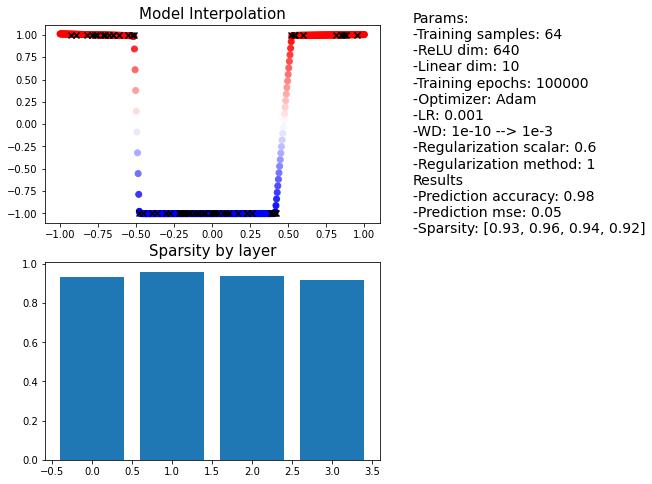

In [22]:
params, report, (fig, ax) = experiment(1, 64, 640, 10, 100000, 1e-3, 0.6, 1)

0: 1.0104559659957886
10000: 0.9755858778953552
20000: 0.9755859971046448
30000: 0.9755859971046448
40000: 0.9755860567092896
turning on regularization
50000: 169.48681640625
60000: 0.975587010383606
70000: 0.9755878448486328
80000: 0.9755889773368835
90000: 0.9755880236625671


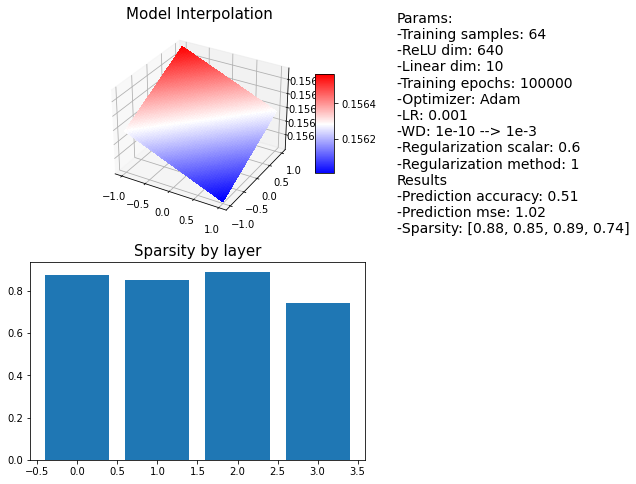

In [17]:
params2D, report2D, (fig2D, ax2D) = experiment(2, 64, 640, 10, 100000, 1e-3, 0.6, 1)

In [23]:
fig.savefig("experiment_1d.png", facecolor="w", bbox_inches="tight")
fig2D.savefig("experiment_2d.png", facecolor="w", bbox_inches="tight")